# Prophet weather prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [ ]:
from prophet import Prophet

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 12)

In [5]:
import warnings
warnings.simplefilter('ignore')

$$
\text { Relative RMSE }=\frac{\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left({Y}_{i}-{V}_{i}\right)^{2}}}{\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left({Y}_{i}-\bar{Y}\right)^{2}}}
$$

In [6]:
def relative_rmse(target, preds):
    rmse = mean_squared_error(target, preds, squared=False)
    avg = np.full(len(preds), preds.mean())
    const_rmse = mean_squared_error(target, avg, squared=False)
    return rmse / const_rmse

### Reading data

In [7]:
weather_df = pd.read_csv('NASA_weather_latitude_51.5_longitude_37.0.csv', skiprows=8)
weather_df["DATE"] = pd.to_datetime(weather_df["DAY"], format='%Y%m%d')

In [8]:
weather_df.head()

,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
0,19840101,2500.0,-5.20,0.26,0.479845,7.59,2.93,NaN,1984-01-01
1,19840102,3250.0,0.30,1.26,0.610800,7.50,2.77,NaN,1984-01-02
2,19840103,4240.0,-1.74,0.99,0.534874,7.11,0.72,NaN,1984-01-03
3,19840104,2740.0,-1.13,0.66,0.592380,5.12,0.44,NaN,1984-01-04
4,19840105,1890.0,-3.70,0.99,0.569003,3.09,0.88,NaN,1984-01-05


### Train - test split

In [9]:
train_tmp = weather_df[weather_df.DATE.dt.year > 1999].copy()
train_data = train_tmp[train_tmp.DATE.dt.year < 2015].copy()

In [10]:
test_tmp = weather_df[weather_df.DATE.dt.year > 2014].copy()
test_data = test_tmp[test_tmp.DATE.dt.year < 2020].copy()

In [11]:
display(train_data.head())
display(test_data.tail())

,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
5844,20000101,3550.0,-12.80,-7.20,0.276993,1.56,1.21,NaN,2000-01-01
5845,20000102,4140.0,-12.74,-6.73,0.297244,3.87,2.47,NaN,2000-01-02
5846,20000103,4590.0,-16.81,-11.44,0.185930,1.34,0.40,NaN,2000-01-03
5847,20000104,4600.0,-15.39,-8.39,0.220140,2.95,0.12,NaN,2000-01-04
5848,20000105,3610.0,-11.50,-5.81,0.310407,3.70,0.65,NaN,2000-01-05


,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
13144,20191227,1280.0,-1.88,0.75,0.547656,1.42,1.23,NaN,2019-12-27
13145,20191228,990.0,-3.79,-1.13,0.423742,3.27,1.59,NaN,2019-12-28
13146,20191229,1070.0,-6.74,-3.27,0.356630,2.94,1.63,NaN,2019-12-29
13147,20191230,750.0,-6.81,-3.80,0.363870,3.76,0.47,NaN,2019-12-30
13148,20191231,1200.0,-3.92,-0.81,0.474842,6.01,2.31,NaN,2019-12-31


<AxesSubplot:>

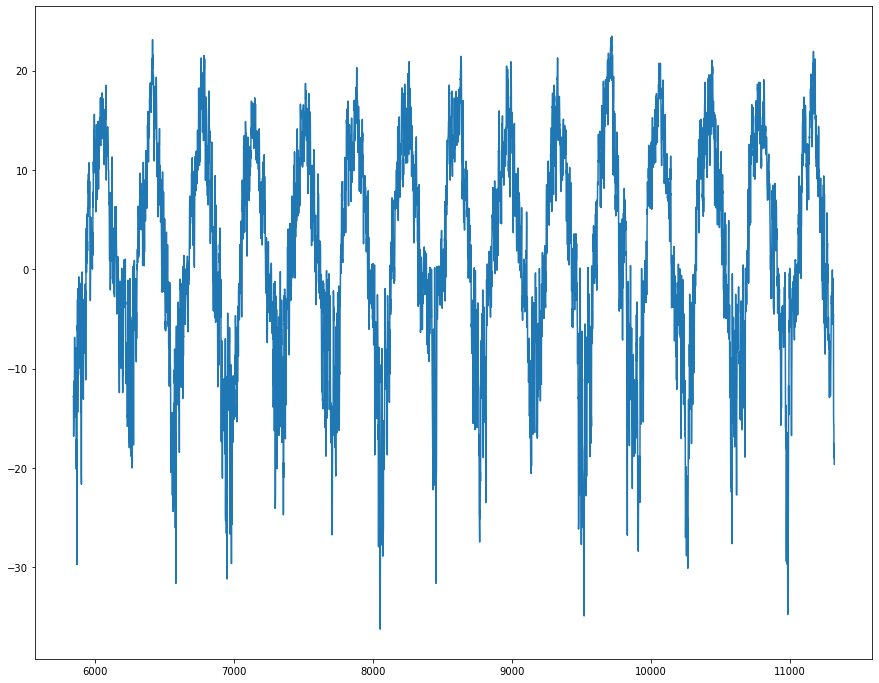

In [12]:
train_data.TMIN.plot()

## Utils

In [13]:
def train_prophet(train, name):
    train_ds = train[['DATE', f'{name}']].copy()
    train_ds.reset_index(drop=True)
    train_ds = train_ds.rename(columns={"DATE": "ds", f"{name}": "y"})

    model = Prophet()
    model.fit(train_ds)
    future = model.make_future_dataframe(periods=1826, include_history=False)
    forecast = model.predict(future)

    return forecast.yhat_lower.to_numpy(), forecast.yhat.to_numpy(), forecast.yhat_upper.to_numpy()

In [14]:
def visulize(df, name):
    plt.title(f"{name} prediction")
    df[f'{name}'].plot()
    df[f'{name}_MED'].plot()
    df[f'{name}_LOW'].plot()
    df[f'{name}_UP'].plot()
    plt.legend(["Ground Truth", "Yhat", "Yhat Lower", "Yhat Upper"]);

In [15]:
def metrics(df, name):
    rmse = mean_squared_error(df[f'{name}'], df[f'{name}_MED'], squared=False)
    rrmse = relative_rmse(df[f'{name}'], df[f'{name}_MED'])

    print("RMSE:\t%.4f" % rmse)
    print("Relative RMSE:\t%.4f" % rrmse)

## IRRAD

In [16]:
irrad_low, irrad_med, irrad_up = train_prophet(train_data, "IRRAD")
test_data['IRRAD_LOW'], test_data['IRRAD_MED'], test_data['IRRAD_UP'] = irrad_low, irrad_med, irrad_up

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -401.58
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        8481.5   1.00973e-06       79.8241           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        8481.5   5.83545e-07       66.1778           1           1      133   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [17]:
metrics(test_data, 'IRRAD')

RMSE:	4076.1365
Relative RMSE:	0.4816


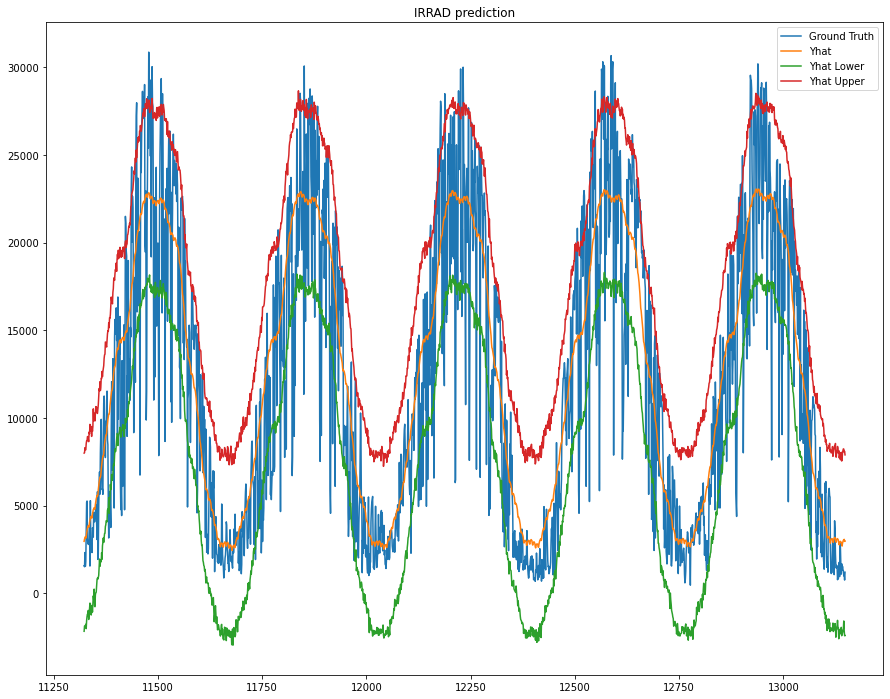

In [18]:
visulize(test_data, 'IRRAD')

## TMIN

In [19]:
tmin_low, tmin_med, tmin_up = train_prophet(train_data, "TMIN")
test_data['TMIN_LOW'], test_data['TMIN_MED'], test_data['TMIN_UP'] = tmin_low, tmin_med, tmin_up

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -937.018
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8430.26   0.000227861       140.305      0.4923      0.4923      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8431.06   2.58243e-06       75.6295      0.3401           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       8431.06   3.68523e-07       74.5644           1           1      289   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


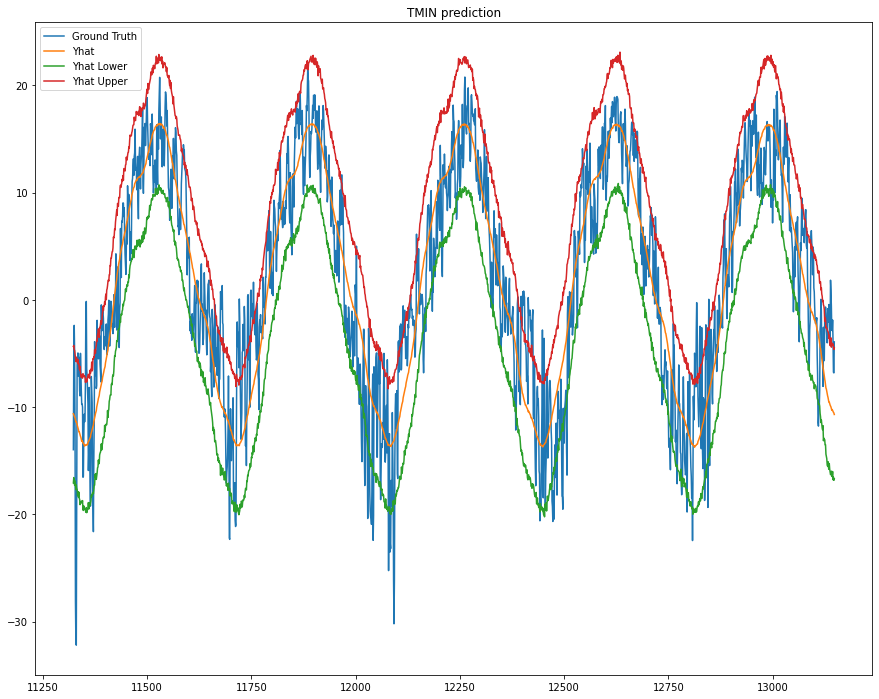

In [20]:
visulize(test_data, 'TMIN')

In [21]:
metrics(test_data, 'TMIN')

RMSE:	4.4604
Relative RMSE:	0.4326


## TMAX

In [22]:
tmax_low, tmax_med, tmax_up = train_prophet(train_data, "TMAX")
test_data['TMAX_LOW'], test_data['TMAX_MED'], test_data['TMAX_UP'] = tmax_low, tmax_med, tmax_up

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -1064.96
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9189.68    0.00152765       69.4517           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       9190.31   0.000168134       74.8488   2.884e-06       0.001      239  LS failed, Hessian reset 
     199       9190.38   7.38874e-05       58.3799      0.4262      0.4262      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       9190.53   2.85053e-05       55.0199   4.037e-07       0.001      443  LS failed, Hessian reset 
     299       9190.53   1.85109e-05       67.3323           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       9190.53   2.48642e-06       74.2819    3.44e-08       0.001      522  LS failed, Hessian rese

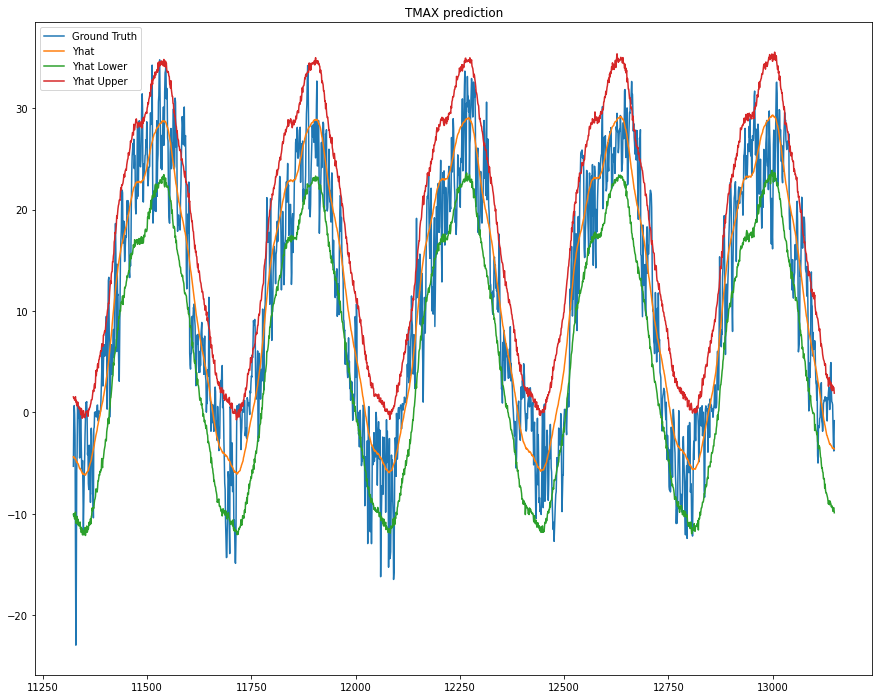

In [23]:
visulize(test_data, 'TMAX')

In [24]:
metrics(test_data, 'TMAX')

RMSE:	4.4053
Relative RMSE:	0.3568


## VAP

In [25]:
vap_low, vap_med, vap_up = train_prophet(train_data, "VAP")
test_data['VAP_LOW'], test_data['VAP_MED'], test_data['VAP_UP'] = vap_low, vap_med, vap_up

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -324.686
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10270.5    0.00047144       171.324      0.3702      0.3702      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10273.1   0.000387568       77.0387      0.5606     0.05606      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10274.1   0.000157821       58.5523           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       10274.1   0.000134397       94.0777   2.112e-06       0.001      450  LS failed, Hessian reset 
     374       10274.2   0.000139731       101.688   2.092e-06       0.001      572  LS failed, Hessian reset 
     399       10274.2   3.44272e-05        67.482           1           1      608   
    Iter      log pro

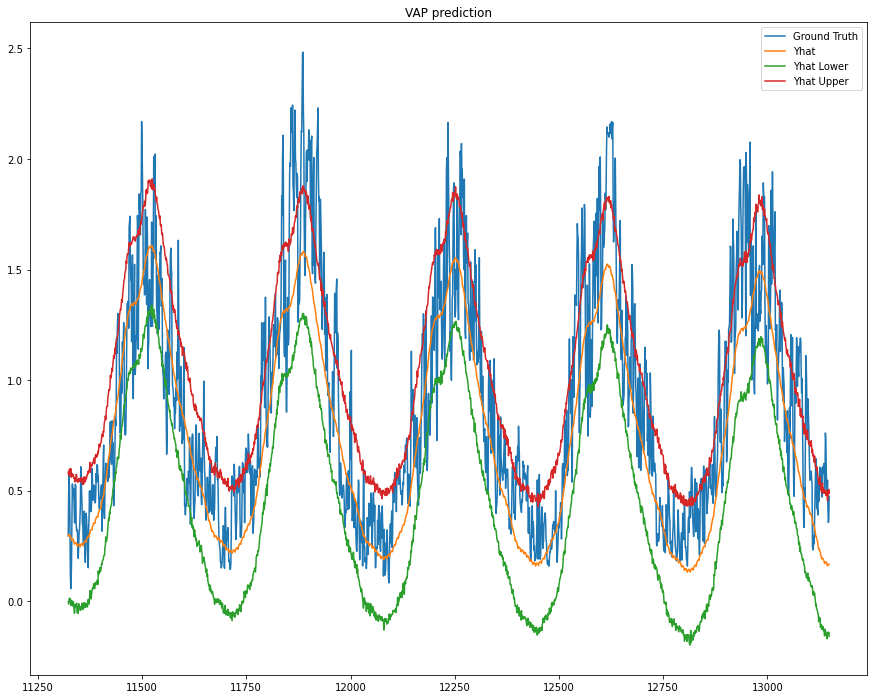

In [26]:
visulize(test_data, 'VAP')

In [27]:
metrics(test_data, 'VAP')

RMSE:	0.2809
Relative RMSE:	0.5206


## WIND

In [28]:
wind_low, wind_med, wind_up = train_prophet(train_data, "WIND")
test_data['WIND_LOW'], test_data['WIND_MED'], test_data['WIND_UP'] = wind_low, wind_med, wind_up

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -62.1616
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9025.45   0.000420593       128.964           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       9025.87    0.00030298       196.539   1.727e-06       0.001      203  LS failed, Hessian reset 
     194       9026.11   0.000166856       117.439    1.52e-06       0.001      309  LS failed, Hessian reset 
     199       9026.13   4.82581e-05       68.9401      0.9975      0.9975      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       9026.15   2.53783e-07        58.721       0.598       0.598      368   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


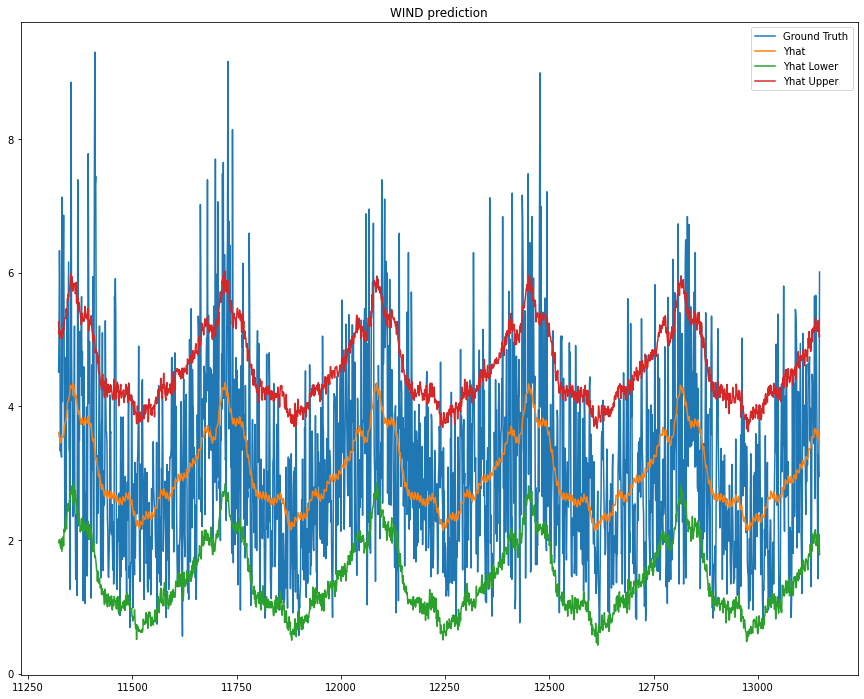

In [29]:
visulize(test_data, 'WIND')

In [30]:
metrics(test_data, 'WIND')

RMSE:	1.2714
Relative RMSE:	0.9122


## RAIN

In [31]:
rain_low, rain_med, rain_up = train_prophet(train_data, "RAIN")
test_data['RAIN_LOW'], test_data['RAIN_MED'], test_data['RAIN_UP'] = rain_low, rain_med, rain_up 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -31.33
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10033.6   1.40019e-06       66.6096      0.2715      0.2715      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       10033.6    1.1232e-06       61.2322      0.6466      0.6466      216   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


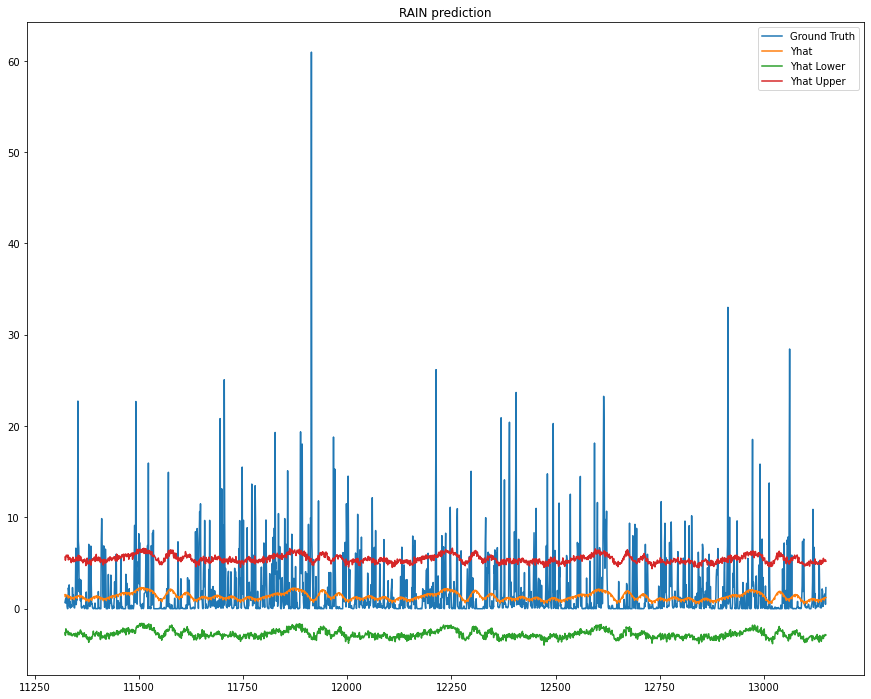

In [32]:
visulize(test_data, 'RAIN')

In [33]:
metrics(test_data, 'RAIN')

RMSE:	3.7642
Relative RMSE:	1.0027
